# Όνομα: Χρυσοβαλάντης-Κων/νος
# Επίθετο: Ανδρεάς
# Α.Μ: 03118102

# <html><font size=6><B>3η εργαστηριακή άσκηση</B><BR>
<BR><B>Link prediction - Πρόβλεψη συνδέσμων</B></BR>
</font></html>

In [ ]:
!pip install --upgrade networkx
!pip3 install --upgrade scipy

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler 

%matplotlib inline

In [ ]:
!pip3 install --upgrade node2vec

In [ ]:
!pip3 uninstall numpy

In [ ]:
!pip install numpy --upgrade

In [ ]:
import numpy as np
from node2vec import Node2Vec   
import multiprocessing 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <html><font size=4><B>1. Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων</B></font>
<li><B>1(i).</B> Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>. Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.</a><BR>
        <B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.<BR></html>

In [ ]:
path = '/content/drive/MyDrive/sca/dbpedia-similar/out.dbpedia-similar'

Graph with 430 nodes and 565 edges


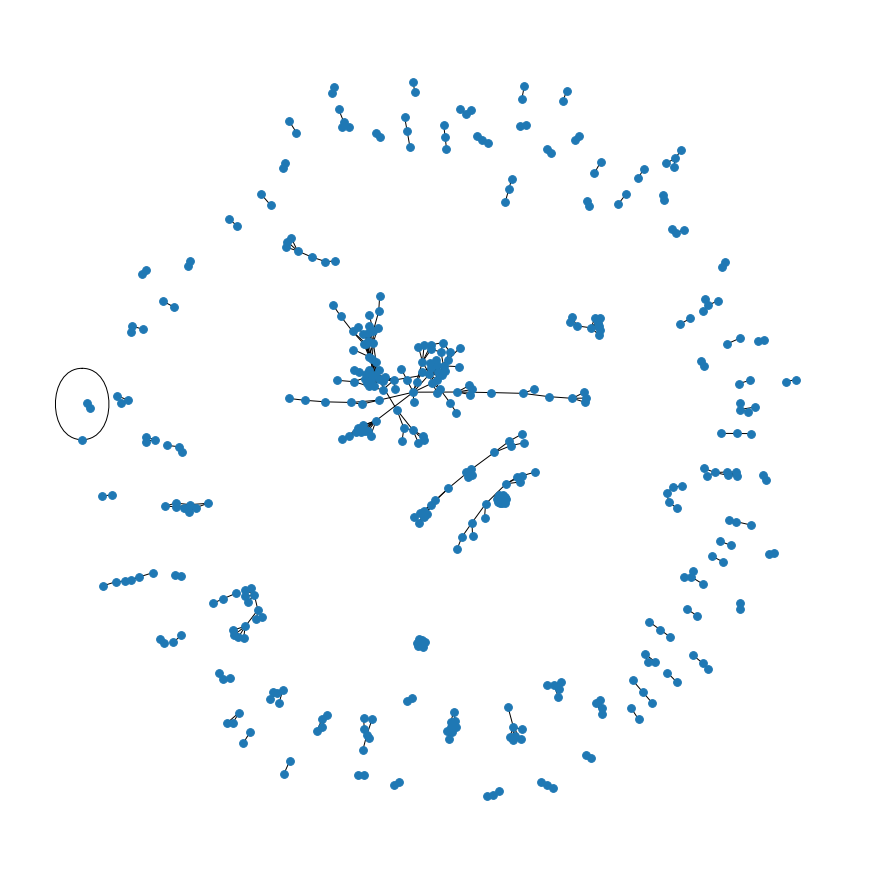

In [ ]:
G = nx.read_edgelist(path, nodetype=int, comments='%')
print(G)

plt.figure(figsize=(12,12))  
nx.draw(G,node_size=60)

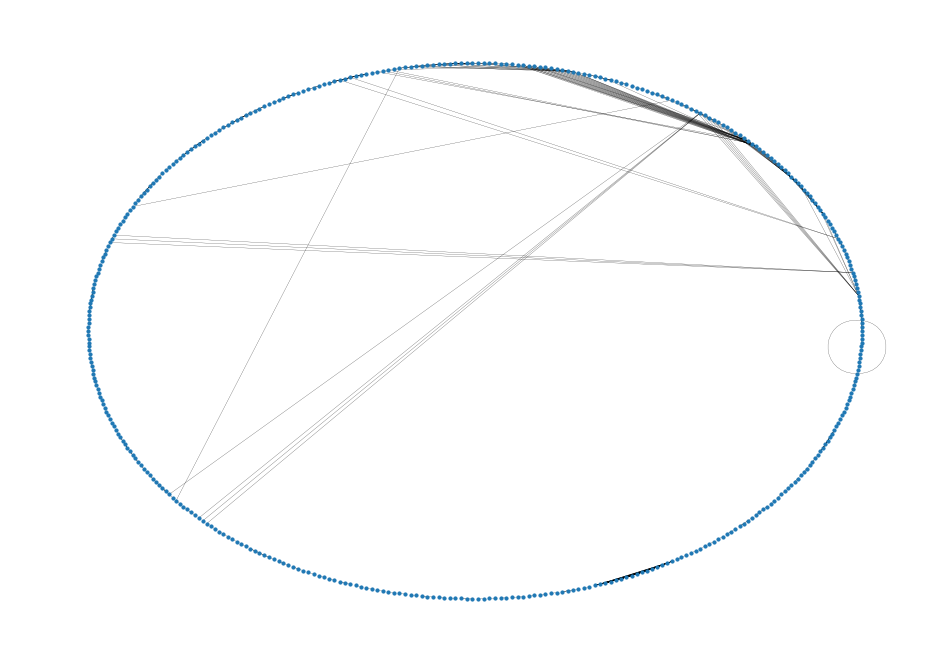

In [ ]:
plt.figure(figsize=(13,9))  
nx.draw_circular(G,node_size=10, width=.2)

Παρατηρούμε ένα self loop το οποίο στην συνέχεια αφαιρούμε

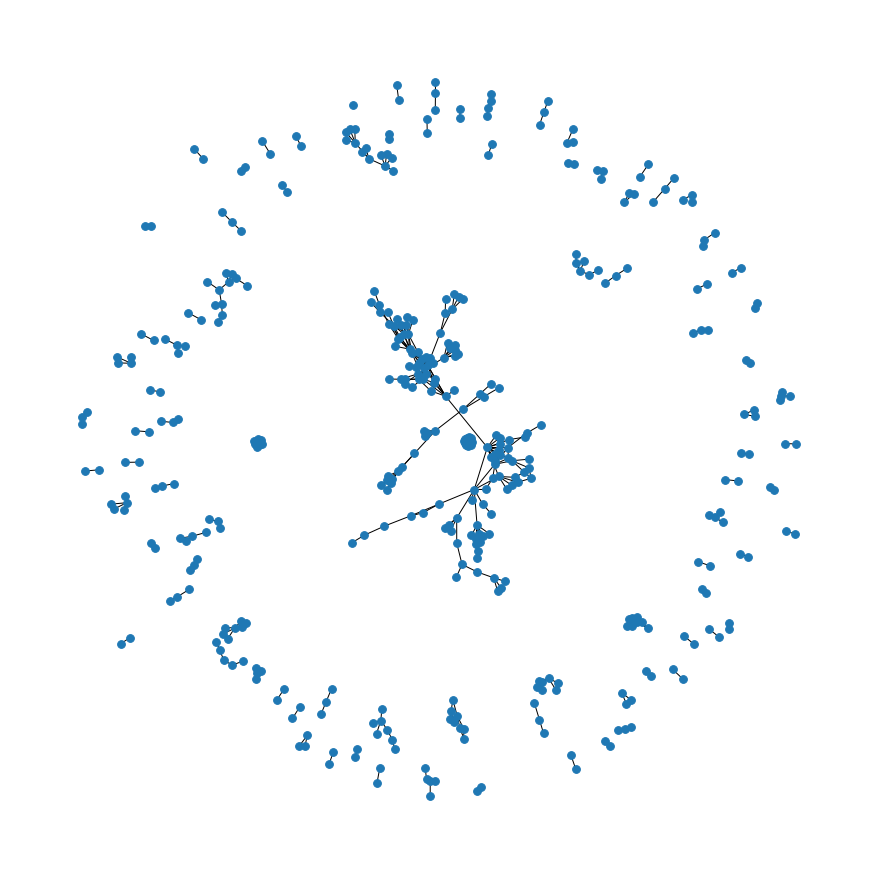

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))

plt.figure(figsize=(12,12))  
nx.draw(G,node_size=60)

To dataset δεν είναι δυνατόν να περιέχει διπλότυπα των ακμών καθώς το πακέτο networkx χειρίζεται τις ακμές ως λεξικά και δεν είναι δυνατόν να υπάρχει διπλότυπο σε λεξικό.

 <li><B>1(ii).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.</li><BR>

In [ ]:
initial_node_count = nx.nodes(G)         
initial_edges_count = nx.edges(G)
initial_mean_node_degree = sum([degree for (node,degree) in G.degree])/len(initial_node_count)
initial_connected_components = nx.number_connected_components(G)

print("""
initial_node_count = {}
initial_edges_count = {}
initial_mean_node_degree = {:.5}
initial_connected_components = {}
""".format(len(initial_node_count), len(initial_edges_count), initial_mean_node_degree, 
           initial_connected_components))


initial_node_count = 430
initial_edges_count = 564
initial_mean_node_degree = 2.6233
initial_connected_components = 95



Παρατηρούμε πώς ο αριθμός των ακμών μειώθηκε κατά ένα καθώς αφαιρέσαμε το self loop του γράφου.

<li><B>1(iii). </B>Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.</li><BR>

In [ ]:
X = nx.adjacency_matrix(G).toarray()

unconnected_pairs = [((i+1, j+1)) for i in range(0, len(initial_node_count)) 
                     for j in range(i+1,len(initial_node_count)) if X[i][j]==0]

print("The number of unconnected pairs is: {}".format(len(unconnected_pairs)))

<ipython-input-9-2526908d1907>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  X = nx.adjacency_matrix(G).toarray()


The number of unconnected pairs is: 91671


Για να υπολογίσουμε τα unconnected pairs διατρέχουμε τον πίνακα γειτνίασης και κρατάμε τα ζευγάρια κόμβων με τιμή 0.

<li><B>1(iv).</B> Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.</li><BR>

In [ ]:
tmp_G = G.copy()
removable_edges = []

for edge in initial_edges_count:
  tmp_G.remove_edge(*edge)
  
  if (nx.number_connected_components(tmp_G) == initial_connected_components and len(nx.nodes(tmp_G)) == len(initial_node_count)):
    removable_edges.append(edge)
  else:
    tmp_G.add_edge(*edge)

print("The number of removable edges is {}".format(len(removable_edges)))

The number of removable edges is 229


<li><B>1(vα).</B> Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1(iii) και 1(iv) (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>
    <li><B>1(vβ).</B> Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1(iv). <BR>
    <li><B>1(vγ).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

In [ ]:
#dataframe of removable edges (they will function as positive samples)
df_removable_edges = pd.DataFrame(removable_edges, columns=['start_node', 'end_node'])
df_removable_edges['link'] = 1

#dataframe of unconnected node pairs (they will function as negative samples)
df_unconnected_pairs = pd.DataFrame(unconnected_pairs, columns=['start_node', 'end_node'])
df_unconnected_pairs['link'] = 0

#merge in one dataframe
frames = [df_removable_edges, df_unconnected_pairs]
df = pd.concat(frames)

#build graph G'=G_reduced
G_reduced = tmp_G.copy()

G_reduced_node_count = nx.nodes(G_reduced)         
G_reduced_edges_count = nx.edges(G_reduced)
G_reduced_mean_node_degree = sum([degree for (node,degree) in G_reduced.degree])/len(G_reduced_node_count)
G_reduced_connected_components = nx.number_connected_components(G_reduced)

print("""
G_reduced_node_count = {}
G_reduced_edges_count = {}
G_reduced_mean_node_degree = {:.5}
G_reduced_connected_components = {}
""".format(len(G_reduced_node_count), len(G_reduced_edges_count), G_reduced_mean_node_degree, 
           G_reduced_connected_components))


G_reduced_node_count = 430
G_reduced_edges_count = 335
G_reduced_mean_node_degree = 1.5581
G_reduced_connected_components = 95



Η μείωση του μέσου βαθμού κόμβου που παρατηρούμε είναι αναμενόμενη λόγω της αφαίρεσης ακμών από τον γράφο.

In [ ]:
df

,start_node,end_node,link
0,1,2,1
1,1,3,1
2,1,4,1
3,3,4,1
4,3,5,1
...,...,...,...
91666,426,430,0
91667,427,428,0
91668,427,429,0
91669,427,430,0


Παρατηρούμε πώς το index στον πίνακα φαίνεται να σταματάει στο 91670, ενώ το shape του είναι (91900,3). Αυτό οφείλεται στο γεγονός πώς έχουμε κάνει concatinate τα δύο dataframes: removable_edges & unconnected_pairs, με το df.removable_edges να είναι πρώτο και το df.unconnected_pairs να είναι δεύτερο. Έτσι, το df μας θα ξεκινάει με index [0-228] και θα συνεχίζει με [0-91670].

## <html><font size=4><B>2. Εισαγωγή σε similarity-based μετρικές για Link prediction</B></font><BR><BR>
<li> Η μετρική <B>Jaccard Coefficient (JC)</B> των κόμβων ${u}$ και ${v}$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.  <B></B>
        <li> Η μετρική <B>Preferential Αttachment (PA)</B> των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li>
        <li> Η μετρική <B>Resource Allocation (RA)</B> των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li><BR><BR>
    <li><B>2(i).</B> Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1(vβ), υπολογίστε την μετρική <B>Jaccard Coefficient (JC)</B>.  <u><a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction">Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX.</a></u> <BR><BR>
    <li><B>2(ii). </B>Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.
        (Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.)</li><BR>
    <li><B>2(iii). </B>Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα <BR>
    $Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα</li> 
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα</li><BR><BR>
        <B><U>Υπόδειξη:</U></B>
        Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
        <li>Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iv)).</li>
        <li>Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iii)).</li>
        <li>Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.</li>   
<li>Από το ερώτημα 1(iii) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.</li> <li>Από το ερώτημα 1(iv) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.</li><BR></html>

In [ ]:
#2(i)

preds = nx.jaccard_coefficient(G_reduced)

#2(ii)

k = [(-1, -1, -1), (-1,-1,-1)] 

for u,v,p in preds:
  if p > k[0][2]:
    k[0] = (u,v,p)
  elif p > k[1][2]:
    k[1] = (u,v,p)

print("The 2 edges with the greatest Jaccard Coefficient are: {} and {}, with Jaccard Coefficient score of {} and {} respectively.".
      format(k[0][:2], k[1][:2], k[0][2], k[1][2]))

The 2 edges with the greatest Jaccard Coefficient are: (4, 46) and (4, 47), with Jaccard Coefficient score of 1.0 and 1.0 respectively.


In [ ]:
#2(iii)

def JC_metrics(threshold_jc):
  preds = nx.jaccard_coefficient(G_reduced)
  
  positive_list = []
  negative_list = []

  for u, v, p in preds:
    if p >= threshold_jc:
      positive_list.append((u,v))
    else:
      negative_list.append((u,v))
  
  tp, tn, fp, fn = 0, 0, 0, 0

  #calculate TP, FN
  for edge in removable_edges:
    if edge in positive_list:
      tp +=1
    else: 
      fn +=1

  #calculate FP, TN
  for edge in unconnected_pairs:
    if edge in positive_list:
      fp +=1
    else:
      tn +=1

  if(tn+fp != len(unconnected_pairs)):
    print("TN + FP != number of unconnected pairs of G")
  
  print(""" 
  TP, FP, FN, TN
  {}, {}, {}, {}
  """.format(tp, fp, fn, tn))

  recall_jc = tp / (tp+fn)
  precision_jc = tp / (tp+fp)
  accuracy_jc = (tp+tn) / (tp+fn+tn+fp)

  return recall_jc, precision_jc, accuracy_jc

For threshold = 0.1:
 
  TP, FP, FN, TN
  160, 431, 69, 91240
  

  Precision = 0.271
  Recall = 0.699
  Accuracy = 0.995

  
For threshold = 0.15:
 
  TP, FP, FN, TN
  156, 417, 73, 91254
  

  Precision = 0.272
  Recall = 0.681
  Accuracy = 0.995

  
For threshold = 0.25:
 
  TP, FP, FN, TN
  153, 382, 76, 91289
  

  Precision = 0.286
  Recall = 0.668
  Accuracy = 0.995

  
For threshold = 0.5:
 
  TP, FP, FN, TN
  138, 272, 91, 91399
  

  Precision = 0.337
  Recall = 0.603
  Accuracy = 0.996

  
For threshold = 1.0:
 
  TP, FP, FN, TN
  126, 204, 103, 91467
  

  Precision = 0.382
  Recall = 0.550
  Accuracy = 0.997

  


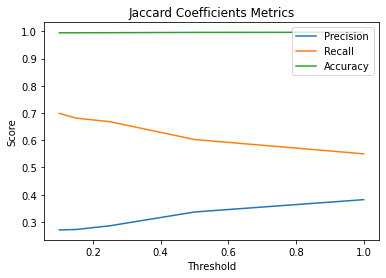

In [ ]:
# check metrics for some threshold values
thresholds = [0.1, 0.15, 0.25, 0.5, 1.0]

recall_list = []
precision_list = []
accuracy_list = []

for threshold in thresholds:
  print("For threshold = {}:".format(threshold))
  
  recall, precision, accuracy = JC_metrics(threshold)

  print("""
  Precision = {:.3f}
  Recall = {:.3f}
  Accuracy = {:.3f}

  """.format(precision, recall, accuracy))

  precision_list.append(precision)
  recall_list.append(recall)
  accuracy_list.append(accuracy)

plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Jaccard Coefficients Metrics')
plt.legend()
plt.show()

Παρατηρούμε πώς για όλες τις τιμές threshold η τιμή της accuracy παραμένει πάρα πολύ υψηλή -μάλιστα είναι σχεδόν ίδια με την επικρατέστερη κλάση του dataset-, ενώ τα precision και recall είναι ασθητά χαμηλότερα.
Όσο αυξάνεται η τιμή του threshold τόσο αυξάνεται το precision, ενώ αντίστροφα μειώνεται το recall. Η συντριπτική πλειοψηφία του dataset μας κατηγοριοποιείται ως True Negative και αυτό εξηγεί τις πολύ υψηλές τιμές του accuracy. Τέλος, παρατηρούμε πώς τα False Positives είναι σταθερά περισσότερα από τα True Positives. Επομένως, μπορούμε να σχολιάσουμε πώς η επίδοση του link prediction μέσω της Jaccard Coefficient δεν είναι βέλτιστη λόγω των χαμηλών επιδόσεων στις τιμές precision και recall.

## <html><font size=4><B>3. Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών</B></font>    
<li><B>3(i).</B> Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> για τον μειωμένο γράφο $G'$. Σημ.: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.
<li><B>3(ii).</B> Εργαστείτε πάνω σε <B><U>αντίγραφο</U></B> του dataframe που κατασκευάσατε στο ερώτημα 1(vα) (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (<B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B>) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

Την συσχέτιση μεταξύ των τιμών των μετρικών Jaccard Coefficient, Preferential Attachment, Resource Allocation μπορούμε να την εξερευνήσουμε μέσω των Pearson και Spearman correlations. Και στις 2 περιπτώσεις αρκεί να υπολογίσουμε τα αποτελέσματα για τις 3 μετρικές και στην συνέχεια μέσω του πακέτου scipy να εισάγουμε την εκάστοτε συνάρτηση και υπολογίσουμε την συσχέτιση των αποτελεσμάτων της εκάστοτε μετρικής με τα δεδομένα του G_reduced. Αν δεν είμαστε σίγουροι για την κατανομή ή την σχέση μεταξύ των μεταβλητών που συγκρίνουμε, η Spearman correlation αποτελεί καλύτερη επιλογή.

In [ ]:
#replicate of the dataframe "unconnected+removables"---dataframe will be used again in (4)
df_new = df.copy()

#dataframe for similarity-based measurement values

#create new 'edge' column were values of type (a,b) are stored and set it as index
df_new.insert(0, "edge", 0)
df_new["edge"] = "(" + df_new['start_node'].astype(str) + "," + df_new['end_node'].astype(str) + ")"
df_new.set_index('edge', inplace=True)

#insert 3 columns were the scores of the 3 metrics will be stored
df_new.insert(3, "Jacc.Coeff.", 0.0)
df_new.insert(4, "Pr.Attachment", 0.0)
df_new.insert(5, "Resource Allocation", 0.0)
df_new

,start_node,end_node,link,Jacc.Coeff.,Pr.Attachment,Resource Allocation
edge,,,,,,
"(1,2)",1,2,1,0.0,0.0,0.0
"(1,3)",1,3,1,0.0,0.0,0.0
"(1,4)",1,4,1,0.0,0.0,0.0
"(3,4)",3,4,1,0.0,0.0,0.0
"(3,5)",3,5,1,0.0,0.0,0.0
...,...,...,...,...,...,...
"(426,430)",426,430,0,0.0,0.0,0.0
"(427,428)",427,428,0,0.0,0.0,0.0
"(427,429)",427,429,0,0.0,0.0,0.0


In [ ]:
#Jaccard Coefficient
for i in range(len(df_new)):
  u = df_new["start_node"][i]
  v = df_new["end_node"][i]
  preds = nx.jaccard_coefficient(G_reduced, [(u,v)])
  for u,v,p in preds: 
    df_new['Jacc.Coeff.'][i] = p

#Preferential Attachment
for i in range(len(df_new)):
  u = df_new["start_node"][i]
  v = df_new["end_node"][i]
  preds = nx.preferential_attachment(G_reduced, [(u,v)])
  for u,v,p in preds: 
    df_new['Pr.Attachment'][i] = p

#Resource Allocation
for i in range(len(df_new)):
  u = df_new["start_node"][i]
  v = df_new["end_node"][i]
  preds = nx.resource_allocation_index(G_reduced, [(u,v)])
  for u,v,p in preds: 
    df_new['Resource Allocation'][i] = p

<ipython-input-19-d113055d8fde>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Jacc.Coeff.'][i] = p
<ipython-input-19-d113055d8fde>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Pr.Attachment'][i] = p
<ipython-input-19-d113055d8fde>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Resource Allocation'][i] = p


In [ ]:
df_new

,start_node,end_node,link,Jacc.Coeff.,Pr.Attachment,Resource Allocation
edge,,,,,,
"(1,2)",1,2,1,0.0,1.0,0.000000
"(1,3)",1,3,1,0.0,2.0,0.000000
"(1,4)",1,4,1,0.0,1.0,0.000000
"(3,4)",3,4,1,0.5,2.0,0.142857
"(3,5)",3,5,1,0.0,4.0,0.000000
...,...,...,...,...,...,...
"(426,430)",426,430,0,0.0,1.0,0.000000
"(427,428)",427,428,0,0.0,2.0,0.000000
"(427,429)",427,429,0,0.0,1.0,0.000000


<li><B>3(iiiα).</B> Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3(ii), για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.</li>
<li><B>3(iiiβ).</B> Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου. </li>
<li><B>3(iiiγ).</B>Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας. </li>  

In [ ]:
X = df_new[['Jacc.Coeff.', 'Pr.Attachment', 'Resource Allocation']] #features
y = df_new['link'] #target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [ ]:
classifier = RandomForestClassifier()   

mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]}

model = GridSearchCV(classifier, param_grid = parameters) 

In [ ]:
model.fit(X_train_scaled, y_train) #train the model

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

In [ ]:
predictions = model.predict(X_test_scaled)

#get (A.M. last digit) first predictions      
print("The first 2 predictions of the model are: {}".format(predictions[:2]))
print("The first 2 labels of our test set to check the accuracy of the above predictions {}".
      format(y_test.head(2)))

acc = accuracy_score(y_test, predictions)
print("The model's accuracy is {:.4f}".format(acc))

The first 2 predictions of the model are: [0 0]
The first 2 labels of our test set to check the accuracy of the above predictions edge
(94,372)     0
(131,204)    0
Name: link, dtype: int64
The model's accuracy is 0.9977


In [ ]:
# locate edge (1,47)
edge_test = df_new.loc[["(1,47)"], ['Jacc.Coeff.', 'Pr.Attachment', 'Resource Allocation']]
print("{}\n".format(edge_test))

predict_proba = model.predict_proba(edge_test.values)
print("""
The propability the nodes (1,47) are linked based on the model is: {:.4f}
and the propability the nodes are not linked is {:.4f}
""".format(predict_proba[0][1], predict_proba[0][0]))

        Jacc.Coeff.  Pr.Attachment  Resource Allocation
edge                                                   
(1,47)          0.0            1.0                  0.0


The propability the nodes (1,47) are linked based on the model is: 0.0033
and the propability the nodes are not linked is 0.9967



In [ ]:
#Dataset Balance

labels=df_new['link']
count_ones=np.sum([labels==1])
count_zeros=np.sum([labels==0])
ones_percent=100*count_ones/(count_ones+count_zeros)
zeros_percent=100*count_zeros/(count_ones+count_zeros)

print("""
    Dataset Balance
Labeled 1: {}
Labeled 0:" {}
Percentage of 1 labels {:.1f}
Percentage of 0 labels {:.1f}
""".format(count_ones, count_zeros, ones_percent, zeros_percent))


    Dataset Balance
Labeled 1: 229
Labeled 0:" 91671
Percentage of 1 labels 0.2
Percentage of 0 labels 99.8



Παρατηρούμε πώς υπάρχει πολύ μεγάλο imbalance μεταξύ των δύο κλάσεων του dataset μας. Γιαυτό τον λόγω καλύτερη μετρική αποτελεί το f1-score αντί του accuracy. To f1-score αποτελεί τον αρμονικό μέσο του Prescision και Recall.
Ένας ακόμη λόγος που το f1-score είναι καλύτερη μετρική είναι το γεγονός πώς στο link prediction μοντέλο που μελετάμε μας ενδιαφέρει ιδιαίτερα να έχουμε χαμηλά FP καθώς δεν είναι καθόλου βολικό για το σύστημά μας να δείχνει πώς υπάρχει σύνδεση μεταξύ 2 κόμβων, ενώ εν τέλει δεν υπάρχει.

## <html><font size=4><B>4. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks) </B></font><BR><BR>
<li><B>4(i).</B> Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
        <BR>Για την επιλογή των παραμέτρων: 
            <li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
                <li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
                 <li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
                     <li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
                         <li>walk_length - μήκος τυχαίου περιπάτου, </li>
                             <li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li><li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
            <li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [ ]:
#generate walks
node2vec_walker = Node2Vec(G_reduced, p=1.0, q=1.0, dimensions=128,
                           num_walks=10, walk_length=80,
                           workers=multiprocessing.cpu_count())

#train node2vec model
n2v_model = node2vec_walker.fit(window=10 , min_count=1)

Computing transition probabilities:   0%|          | 0/430 [00:00<?, ?it/s]

<html><font>
    <li><B>4(ii).</B> Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.</li><BR>
    <li><B>4(iii).</B> Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

In [ ]:
#apply trained Node2Vec model on each node pair of the dataframe "unconnected+removables"
x = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df['start_node'], df['end_node'])]
y = df['link']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 1) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(max_depth=2, random_state=1)

mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

classifier.fit(X_train_scaled, y_train)
predictions = classifier.predict(X_test_scaled)

acc = accuracy_score(y_test, predictions)
print("Accuracy of Node2Vec model is: {}".format(acc))

Accuracy of Node2Vec model is: 0.997170837867247


Παρατηρούμε ελαφρώς μειωμένη απόδοση του μοντέλου Node2Vec, σε σχέση με το μοντέλο που προέκυψε από gridsearch.

<html><font size=4> <B><U>Ερώτηση bonus (+10/100)</U><B>: </font>Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a> ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.</font></html>

**Average**

In [ ]:
x_average = [((n2v_model.wv[str(i)]+n2v_model.wv[str(j)])/2) for i,j in zip(df['start_node'], df['end_node'])]
y = df['link']

X_train, X_test, y_train, y_test = train_test_split(x_average, y, random_state = 1) 

mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

average_classifier = RandomForestClassifier(max_depth=2, random_state=1) 
average_classifier.fit(X_train_scaled, y_train)
average_predictions = average_classifier.predict(X_test_scaled)

average_acc = accuracy_score(y_test, average_predictions)
print("Accuracy of Average Node2Vec model is: {}".format(average_acc))

Accuracy of Average Node2Vec model is: 0.997170837867247


**Hadamard**

In [ ]:
x_hadamard = [(n2v_model.wv[str(i)]*n2v_model.wv[str(j)]) for i,j in zip(df['start_node'], df['end_node'])]
y = df['link']

X_train, X_test, y_train, y_test = train_test_split(x_hadamard, y, random_state = 1)

mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

hadamard_classifier = RandomForestClassifier(max_depth=2, random_state=1) 
hadamard_classifier.fit(X_train_scaled, y_train)
hadamard_predictions = hadamard_classifier.predict(X_test_scaled)

hadamard_acc = accuracy_score(y_test, hadamard_predictions)
print("Accuracy of Hadamard Node2Vec model is: {}".format(hadamard_acc))

Accuracy of Hadamard Node2Vec model is: 0.997170837867247


**Weighted-L1**

In [ ]:
x_weighted_l1 = [(abs((n2v_model.wv[str(i)]-n2v_model.wv[str(j)]))) for i,j in zip(df['start_node'], df['end_node'])]
y = df['link']

X_train, X_test, y_train, y_test = train_test_split(x_weighted_l1, y, random_state = 1)

mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

weighted_l1_classifier = RandomForestClassifier(max_depth=2, random_state=1) 
weighted_l1_classifier.fit(X_train_scaled, y_train)
weighted_l1_predictions = weighted_l1_classifier.predict(X_test_scaled)

weighted_l1_acc = accuracy_score(y_test, weighted_l1_predictions)
print("Accuracy of Weighted-L1 Node2Vec model is: {}".format(weighted_l1_acc))

Accuracy of Weighted-L1 Node2Vec model is: 0.997170837867247


**Weighted-L2**

In [ ]:
x_weighted_l2 = [((abs((n2v_model.wv[str(i)]-n2v_model.wv[str(j)])))**2) for i,j in zip(df['start_node'], df['end_node'])]
y = df['link']

X_train, X_test, y_train, y_test = train_test_split(x_weighted_l2, y, random_state = 1) 

mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

weighted_l2_classifier = RandomForestClassifier(max_depth=2, random_state=1) 
weighted_l2_classifier.fit(X_train_scaled, y_train)
weighted_l2_predictions = weighted_l2_classifier.predict(X_test_scaled)

weighted_l2_acc = accuracy_score(y_test, weighted_l2_predictions)
print("Accuracy of Weighted-L2 Node2Vec model is: {}".format(weighted_l2_acc))

Accuracy of Weighted-L2 Node2Vec model is: 0.997170837867247


Παρατηρούμε πώς το accuracy score είναι ακριβώς το ίδιο για όλα τα μοντέλα.

<html><font size=4><B><U>Βιβλιογραφία:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>